In [7]:
import yfinance as yf
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from scipy.stats import pearsonr

[*********************100%***********************]  1 of 1 completed


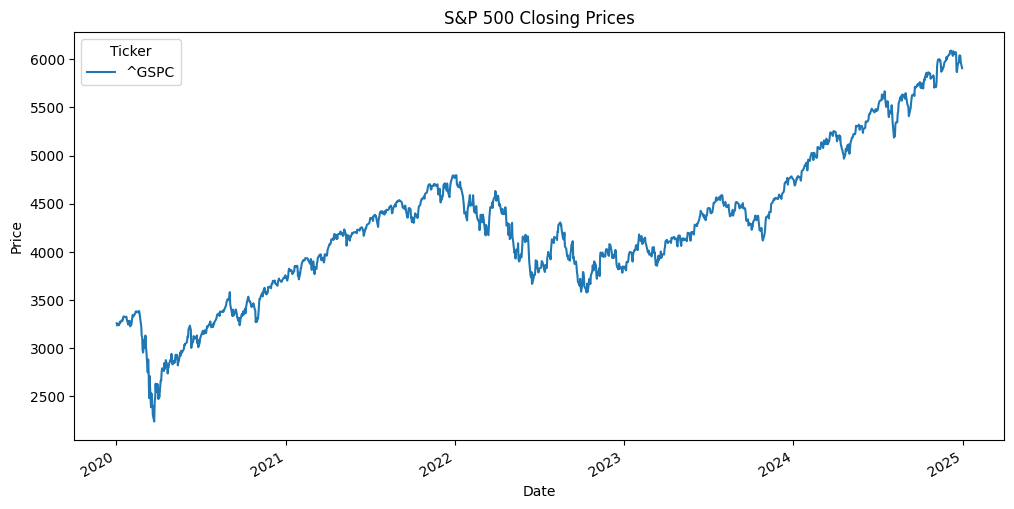

In [17]:
# Step 1: Download the data
sp500 = yf.download('^GSPC', start='2020-01-01', end='2024-12-31')

# Step 3: Plot the closing price
sp500['Close'].plot(figsize=(12, 6), title='S&P 500 Closing Prices')
plt.ylabel("Price")
plt.show()

In [18]:
# Reset index and flatten columns (if needed)
sp500 = sp500.reset_index()
sp500.columns = sp500.columns.get_level_values(0)

# Rename for Prophet
sp500 = sp500.rename(columns={'Date': 'ds', 'Close': 'y'})


# Clean and format
sp500['ds'] = pd.to_datetime(sp500['ds'])
sp500['y'] = sp500['y'].astype(float)
sp500 = sp500.dropna(subset=['ds', 'y'])

# Train-test split (last 30 days as test)
train = sp500.iloc[:-30]
test = sp500.iloc[-30:]

In [19]:
# Prophet model
prophet_model = Prophet(daily_seasonality=True)
prophet_model.fit(train)

16:10:02 - cmdstanpy - INFO - Chain [1] start processing
16:10:02 - cmdstanpy - INFO - Chain [1] done processing


In [20]:
# Future dataframe and prediction
future = prophet_model.make_future_dataframe(periods=30)
forecast = prophet_model.predict(future)

# Extract last 30 days of forecast
prophet_forecast = forecast[['ds', 'yhat']].iloc[-30:]
prophet_forecast.set_index('ds', inplace=True)

# Align test set index
test = test.set_index('ds')

In [21]:
# Calculate metrics
rmse = np.sqrt(mean_squared_error(test['y'], prophet_forecast['yhat']))
mae = mean_absolute_error(test['y'], prophet_forecast['yhat'])
mape = np.mean(np.abs((test['y'] - prophet_forecast['yhat']) / test['y'])) * 100

# R² Score
r2 = r2_score(test['y'], prophet_forecast['yhat'])

# Pearson Correlation Coefficient
pearson_corr, _ = pearsonr(test['y'], prophet_forecast['yhat'])

# Directional accuracy
actual_diff = test['y'].diff().dropna()
pred_diff = prophet_forecast['yhat'].diff().dropna()

# Align indices to ensure they match before comparison
aligned_actual, aligned_pred = actual_diff.align(pred_diff, join='inner')

# Now calculate directional accuracy
directional_accuracy = np.mean((np.sign(aligned_actual) == np.sign(aligned_pred)).values) * 100

# Print metrics
print(f"🔮 Prophet RMSE: {rmse:.2f}")
print(f"📏 MAE: {mae:.2f}")
print(f"📉 MAPE: {mape:.2f}%")
print(f"📈 Directional Accuracy: {directional_accuracy:.2f}%")
print(f"🧮 R² Score: {r2:.4f}")
print(f"🔗 Pearson Correlation: {pearson_corr:.4f}")

🔮 Prophet RMSE: 67.87
📏 MAE: 49.59
📉 MAPE: 0.49%
📈 Directional Accuracy: 68.42%
🧮 R² Score: 0.0733
🔗 Pearson Correlation: 0.3826


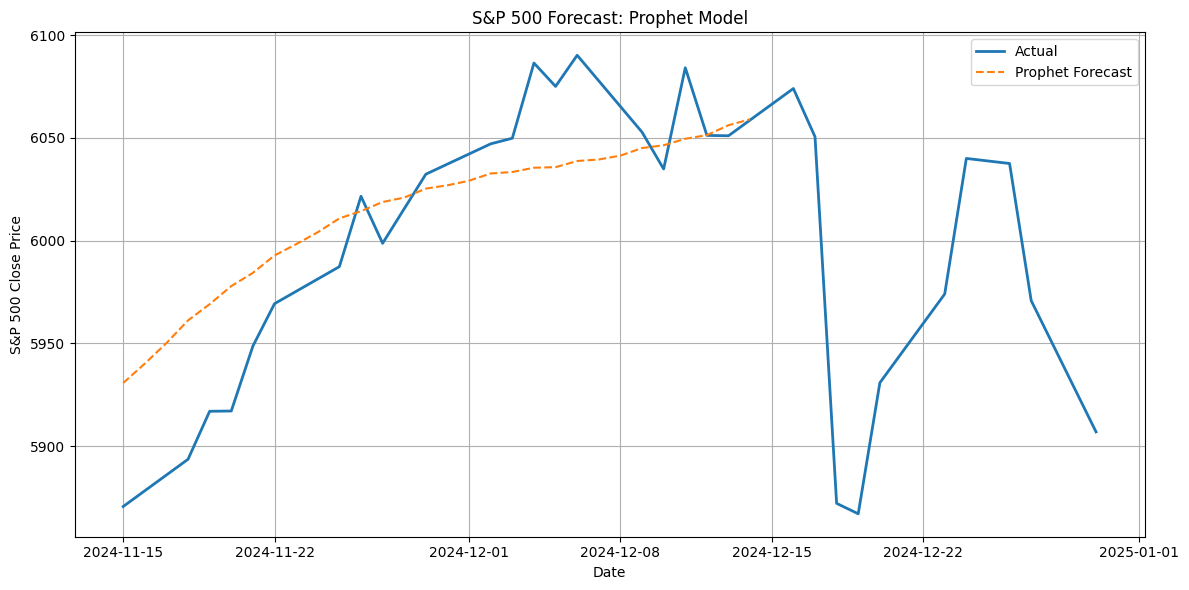

In [22]:
# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['y'], label='Actual', linewidth=2)
plt.plot(prophet_forecast.index, prophet_forecast['yhat'], label='Prophet Forecast', linestyle='--')
plt.title('S&P 500 Forecast: Prophet Model')
plt.xlabel('Date')
plt.ylabel('S&P 500 Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()